In [1]:
#Import packages
import pandas as pd
import numpy as np
import os

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
######################## Define the text size of each plot globally ###########

In [3]:
# =============================================================================
# Import CPT Dataset
# =============================================================================

# File path
file_path = r"..\data\CPT_PremstallerGeotechnik_revised.csv"

# Read the CSV file into a DataFrame
df_raw = pd.read_csv(file_path, low_memory=False)

# Select only SCPTu data
df_SCPTu = df_raw[df_raw['test_type'] == 'SCPTu']
# Select only SCPT data
df_SCPT = df_raw[df_raw['test_type'] == 'SCPT']
# Select both SCPTu and SPT data
df_SCPTu_SCPT = df_raw[(df_raw['test_type'] == 'SCPTu') | (df_raw['test_type'] == 'SCPT')]
df_SCPTu_SCPT_mean = df_raw[(df_raw['test_type'] == 'SCPTu') | (df_raw['test_type'] == 'SCPT')]

selected_columns_x_average = ['Depth (m)','qc (MPa)', 'fs (kPa)', 'Rf (%)', 'u0 (kPa)', "σ',v (kPa)"]

for column in selected_columns_x_average:
    df_SCPTu_SCPT = df_SCPTu_SCPT.copy()
    df_SCPTu_SCPT[column] = df_SCPTu_SCPT.loc[:, column].rolling(window=50).mean()

    df_SCPTu_SCPT_mean = df_SCPTu_SCPT_mean.copy()
    df_SCPTu_SCPT_mean[column+"_mean"] = df_SCPTu_SCPT_mean.loc[:, column].rolling(window=50).mean()

df_SCPTu_SCPT = df_SCPTu_SCPT.dropna(subset=['Vs (m/s)'])
df_SCPTu_SCPT_mean = df_SCPTu_SCPT_mean.dropna(subset=['Vs (m/s)'])

# count number of tests in both subsets
SCPTu_number = df_SCPTu['ID'].nunique()
SCPT_number = df_SCPT['ID'].nunique()
combined_number = df_SCPTu_SCPT['ID'].nunique()


print('Preprocessing:\n')
print('Number of tests in SCPTu =', SCPTu_number)
print('Number of tests in SCPT =', SCPT_number)
print('Number of tests in SCPTu and SCPT =', combined_number)

Preprocessing:

Number of tests in SCPTu = 50
Number of tests in SCPT = 46
Number of tests in SCPTu and SCPT = 96


In [4]:
# Select columns
selected_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','Vs (m/s)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)', '$v_s$ (m/s)'] #for plotting purpose

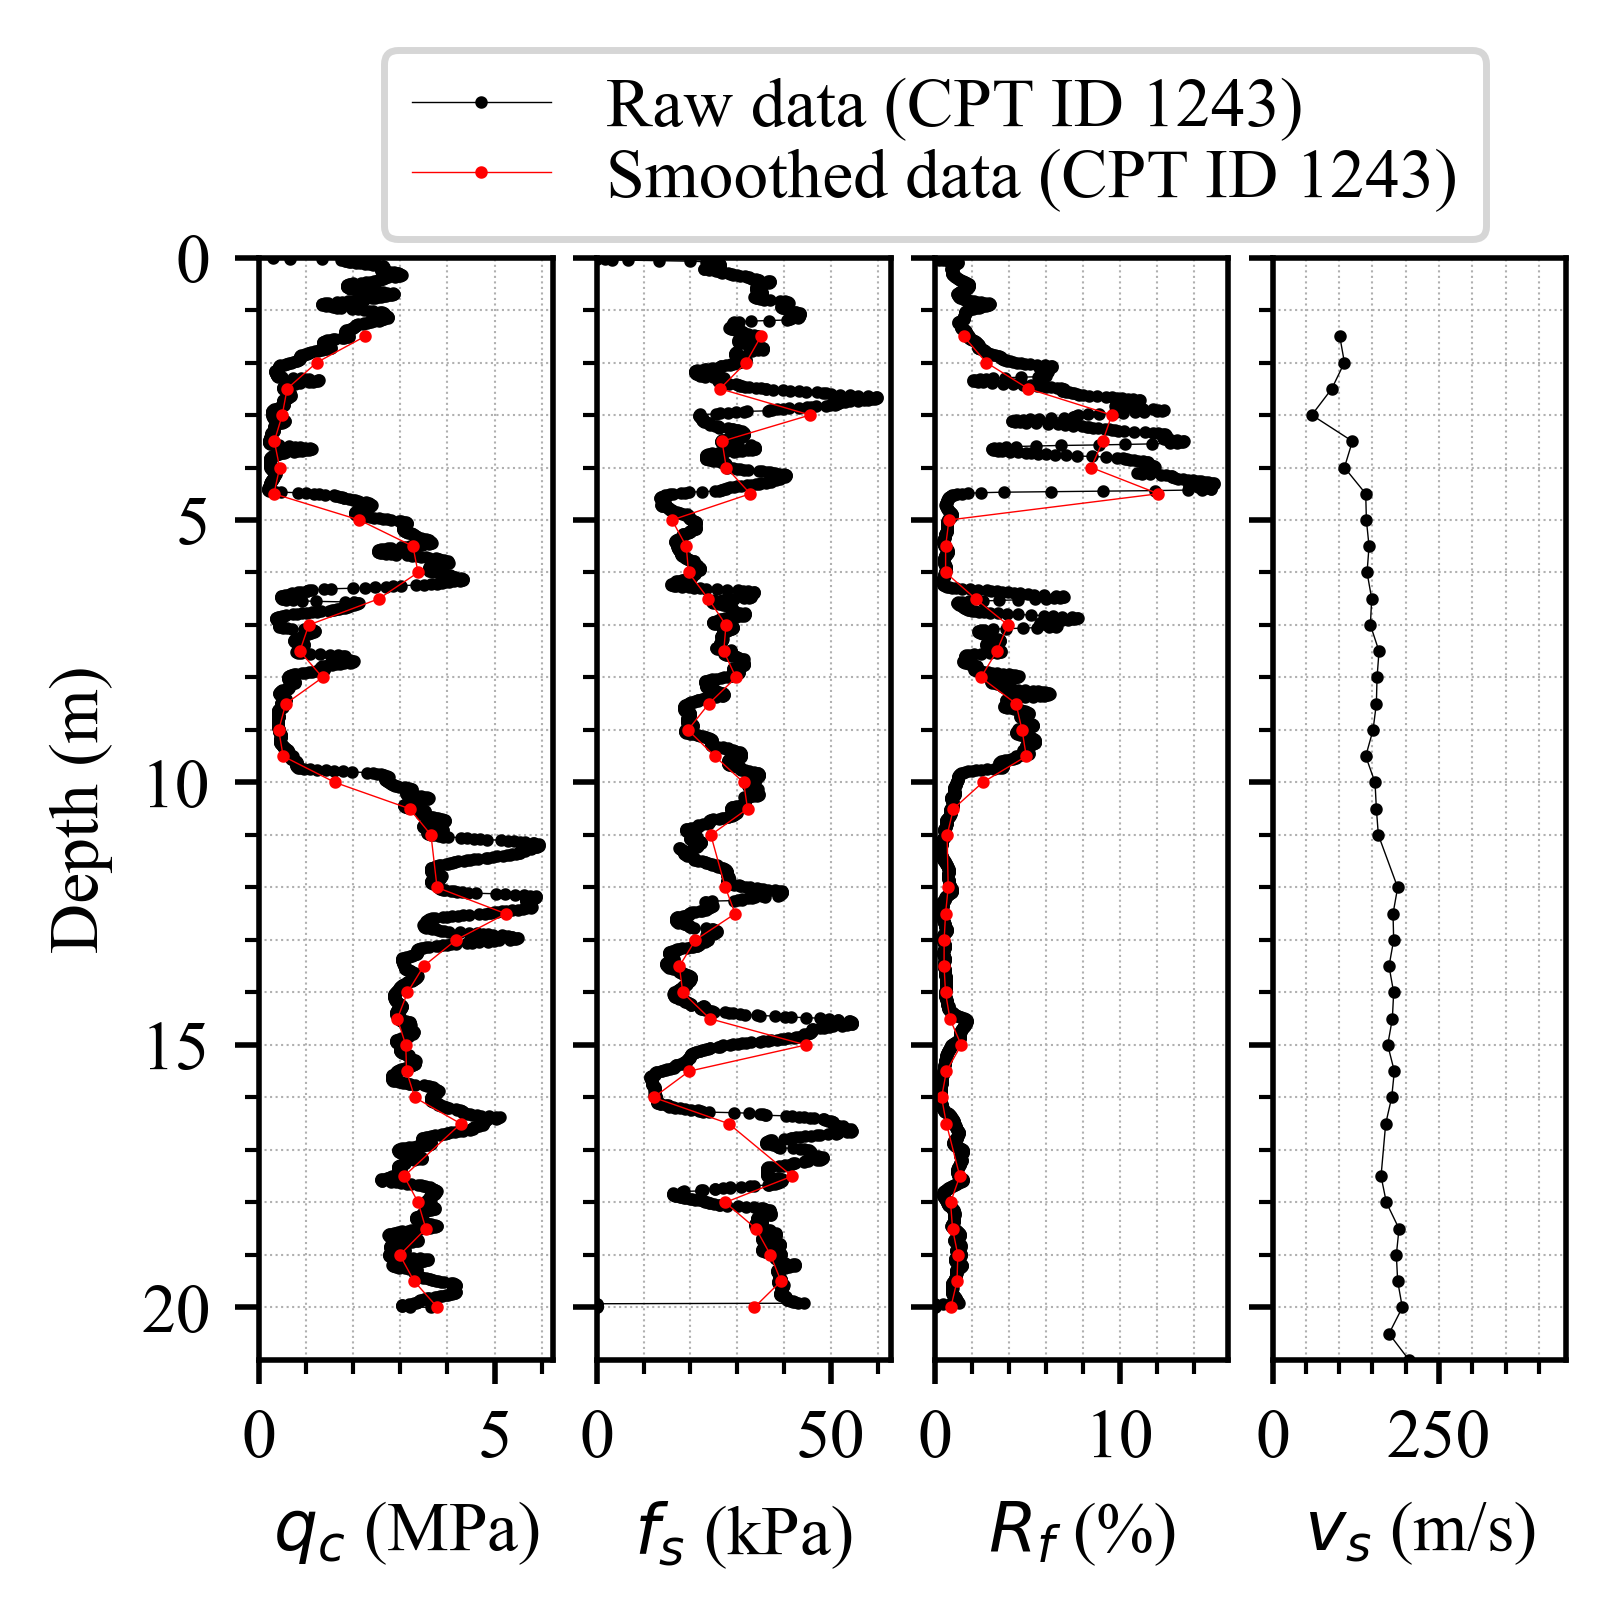

In [5]:
# =============================================================================
# Plotting the data and Selecting features
# =============================================================================
# Plotting CPT data 
cm = 1/2.54  # centimeters in inches

#Plot CPT: raw data and mean data
unique_ids = df_SCPTu_SCPT_mean.loc[:,'ID'].unique()
id_value = np.random.choice(unique_ids)
fig, axes = plot_cpt_data((8*cm, 8*cm), selected_columns_x, df_raw,
              df_SCPTu_SCPT_mean, id_value=id_value,
              plot_columns_x_label=plot_columns_x_label)

axes[0].legend(loc='upper center', bbox_to_anchor=(2.3, 1.22), ncol=1, handlelength = 2, labelspacing=0.1)
plt.subplots_adjust(left=0.15, right=0.98, top=0.85, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig(f"..\\graphics\A_CPT_RAW_filterd_id_{id_value}.png", dpi=1000)

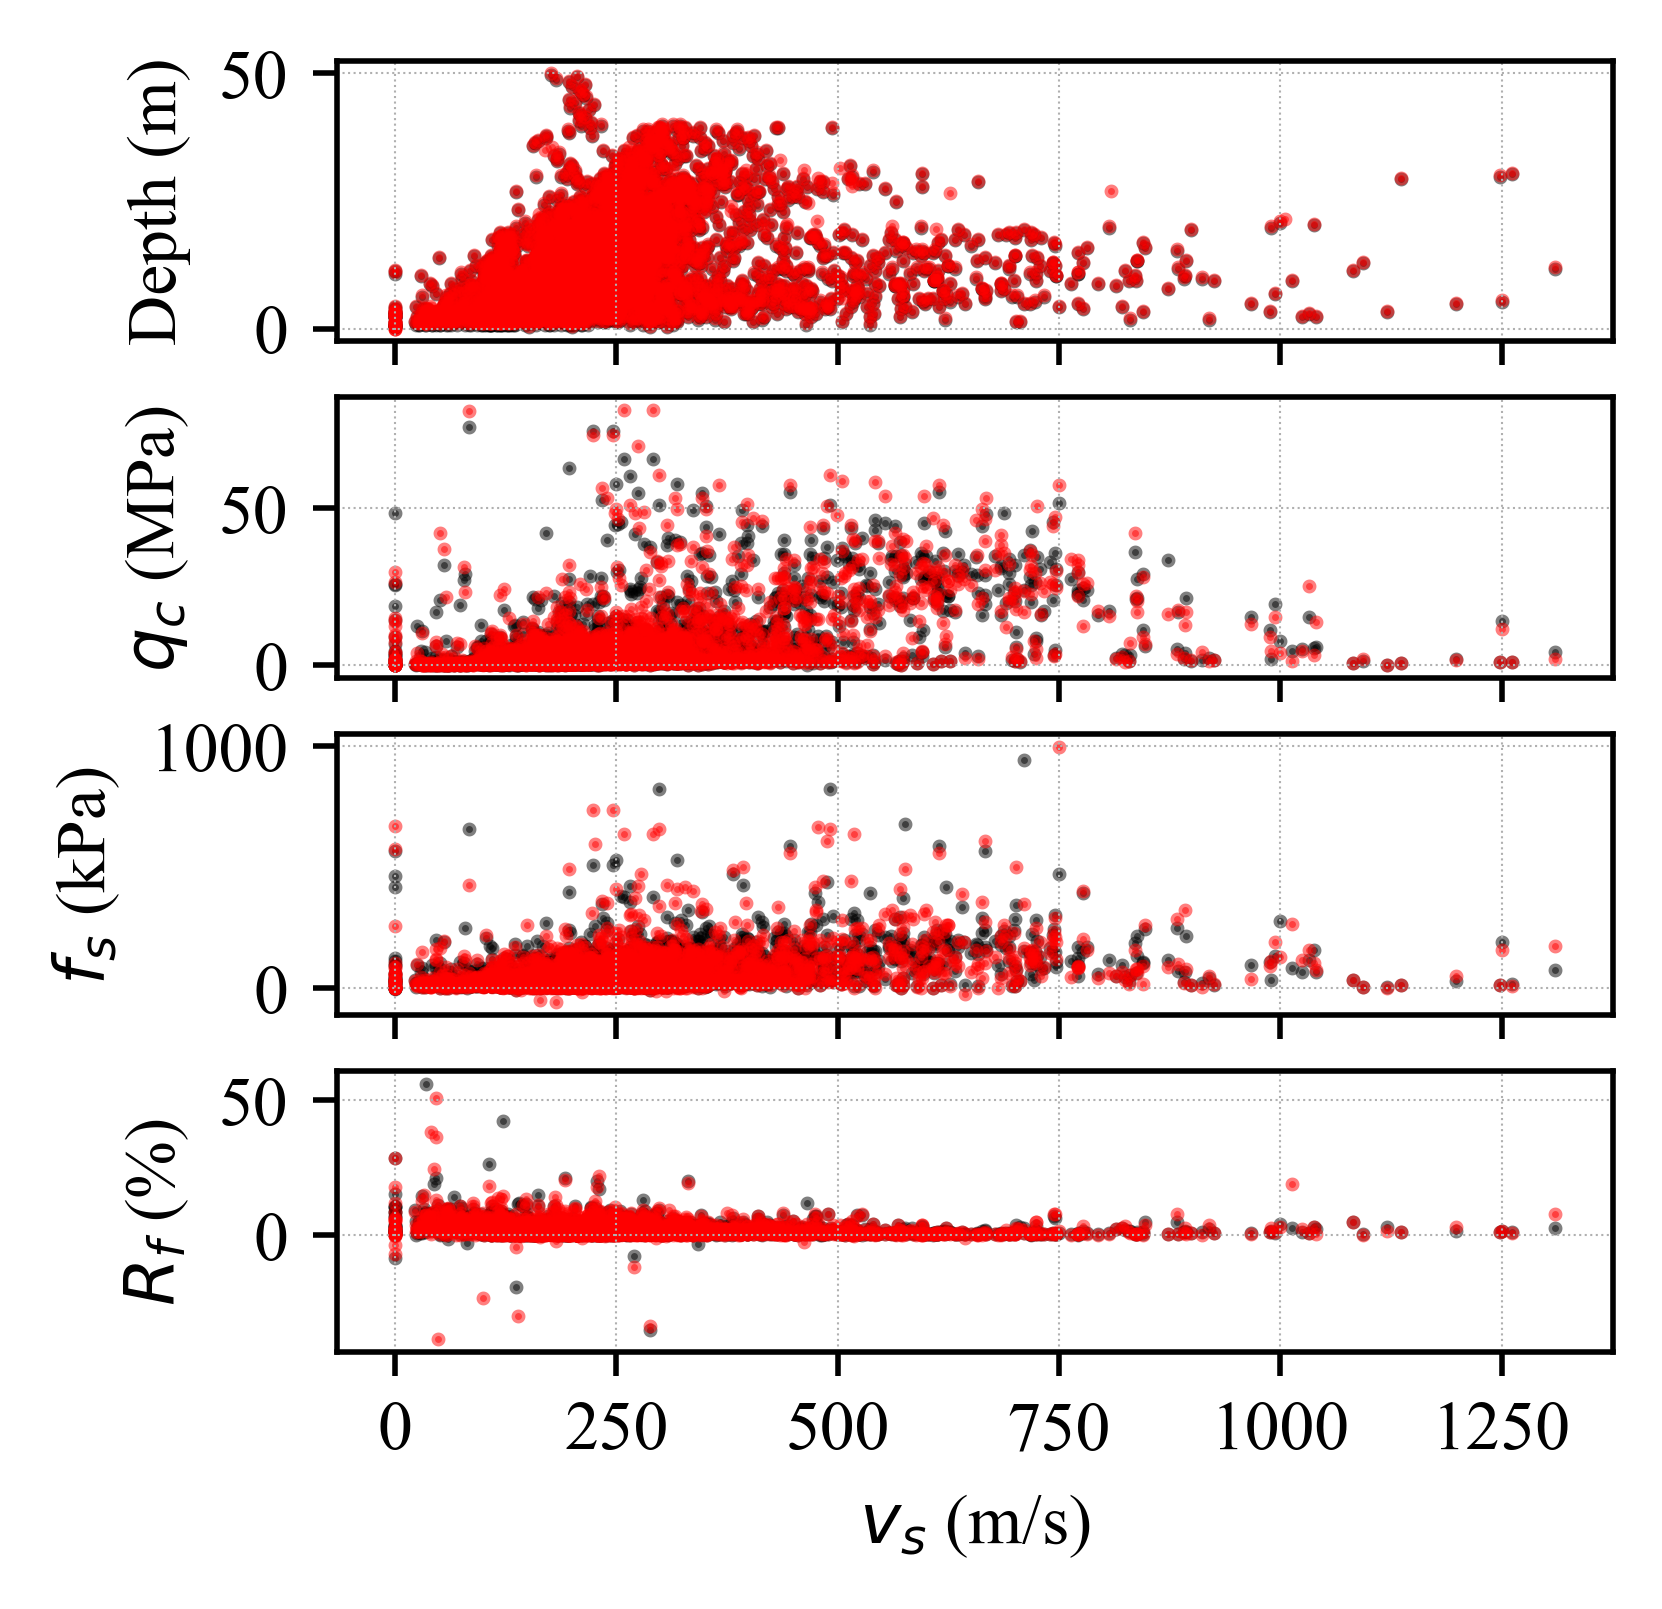

In [32]:
# Plotting training data 

X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()

s = 1  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 0.5

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(8*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, plot_columns_x_label, 'Raw data', False)

########################### REMOVE outliers
#df_SCPTu_SCPT = remove_outliers(df_SCPTu_SCPT, 'Vs (m/s)')
#df_SCPTu_SCPT = df_SCPTu_SCPT[(df_SCPTu_SCPT['Vs (m/s)'] > 0)]

#X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
#y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()
########################### REMOVE outliers

#plotting_raw_data(X,y, alpha, s, 'r', 'Removed outliers', False, axes, plot_columns_x_label)
# Adjust layout to prevent overlapping
plt.subplots_adjust(left=0.18, right=0.99, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig("..\\graphics\B_Raw_data.png", dpi = 1000)

In [7]:
# =============================================================================
# Training of XGB model
# =============================================================================
import xgboost as xgb
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    param = {
        "objective": "reg:squarederror",
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'tree_method': 'hist',
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "reg_alpha":trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda":trial.suggest_float("reg_lambda", 0.01, 1.0),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

c:\Users\haris\Documents\GitHub\ISC7_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-02-06 22:13:06,264] A new study created in memory with name: no-name-90579160-9080-4fec-9eba-929ae62f542c
[I 2024-02-06 22:13:09,110] Trial 0 finished with value: 0.23434812459092397 and parameters: {'n_estimators': 90, 'learning_rate': 0.006838433232551985, 'max_depth': 3, 'subsample': 0.8805053570561394, 'reg_alpha': 0.47948343017982875, 'reg_lambda': 0.10106963192785884}. Best is trial 0 with value: 0.23434812459092397.
[I 2024-02-06 22:13:09,241] Trial 1 finished with value: 0.17230591003928297 and parameters: {'n_estimators': 16, 'learning_rate': 0.019059193215632025, 'max_depth': 5, 'subsample': 0.5655256047613023, 'reg_alpha': 0.7661297418213867, 'reg_lambda': 0.460157127305

In [8]:
# Plot optimization history
plot_optimization_history(study)

In [9]:
# Plot parameter importances
plot_param_importances(study)

In [10]:
best_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 20,
    'tree_method': 'hist',
    "verbosity": 1,
    'learning_rate': 0.3,
    'max_depth': 5,
    'subsample': 0.7,
    'reg_alpha': 0.7,
    'reg_lambda': 0.7,
    'n_jobs': None,
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)

# Train the final model with the best hyperparameters
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03221210654795912,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=84, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
print('Performance of XGB ML model on the test data:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of XGB ML model on the test data:

Test Data - R2: 0.481, MSE: 8505.721.


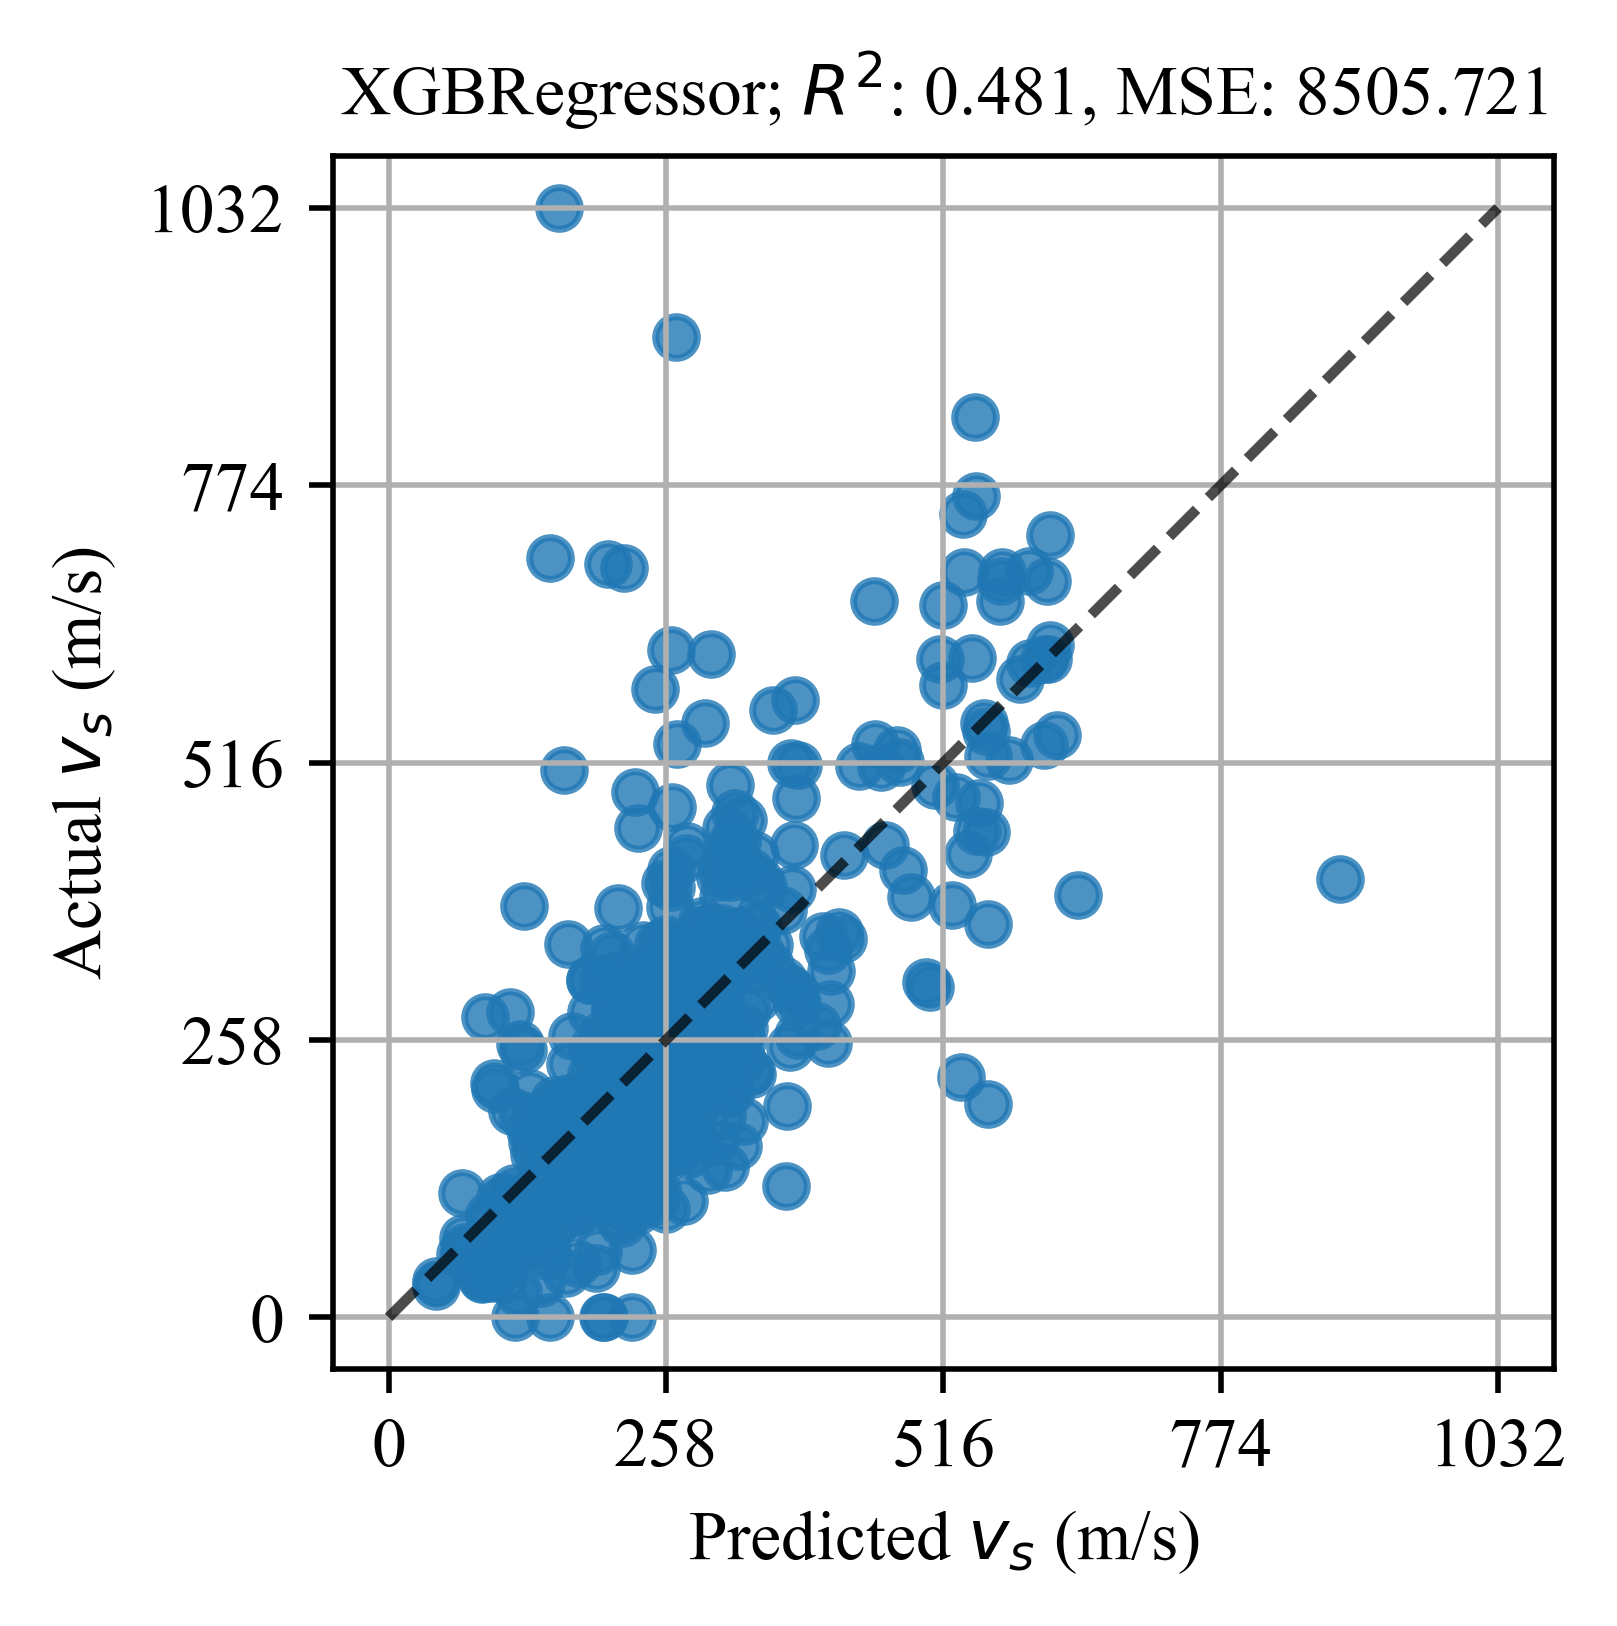

In [12]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'XGBRegressor; $R^2$: {round(score, 3)}, MSE: {round(mse, 3)}')

In [13]:
print('Performance of XGB ML model on train data:\n')
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of XGB ML model on train data:

Training Data - R2: 0.759, MSE: 5070.605.


In [14]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params, random_state=42)

# Fit the model on the entire dataset
final_model.fit(X, y)

joblib.dump(final_model, 'xgb_model.joblib')

['xgb_model.joblib']

In [15]:
# =============================================================================
# Training of machine learning model
# =============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        'loss': "squared_error",
    }

    model = HistGradientBoostingRegressor(**params)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-06 22:15:00,734] A new study created in memory with name: no-name-de7ae57e-1608-437a-abf9-2b919d1b532c
[I 2024-02-06 22:15:02,825] Trial 0 finished with value: 0.24397712785664974 and parameters: {'max_depth': 35, 'max_leaf_nodes': 47, 'l2_regularization': 0.8573261131685949, 'min_samples_leaf': 21, 'learning_rate': 0.00457408839780199}. Best is trial 0 with value: 0.24397712785664974.
[I 2024-02-06 22:15:03,340] Trial 1 finished with value: 0.32177111528327346 and parameters: {'max_depth': 26, 'max_leaf_nodes': 13, 'l2_regularization': 0.09516833852514633, 'min_samples_leaf': 24, 'learning_rate': 0.009426417748190115}. Best is trial 1 with value: 0.32177111528327346.
[I 2024-02-06 22:15:04,907] Trial 2 finished with value: 0.24793644175234944 and parameters: {'max_depth': 66, 'max_leaf_nodes': 46, 'l2_regularization': 0.5767463095804821, 'min_samples_leaf': 39, 'learning_rate': 0.004904411223462863}. Best is trial 1 with value: 0.32177111528327346.
[I 2024-02-06 22:15:05,53

In [16]:
# Plot optimization history
plot_optimization_history(study)

In [17]:
# Plot parameter importances
plot_param_importances(study)

In [18]:
best_params = {
    'max_depth': 1,
    'max_leaf_nodes': 2,
    'l2_regularization': 1,
    'min_samples_leaf': 1,
    'learning_rate': 1,
    'loss': "squared_error",
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = HistGradientBoostingRegressor(**best_params)

# Train the final model on the entire training set
final_model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=0.17635986634202172,
                              learning_rate=0.03669481778280365, max_depth=87,
                              max_leaf_nodes=48, min_samples_leaf=10)

In [19]:
print('Performance of HistGradientBoostingRegressor ML model:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of HistGradientBoostingRegressor ML model:

Test Data - R2: 0.462, MSE: 8807.691.


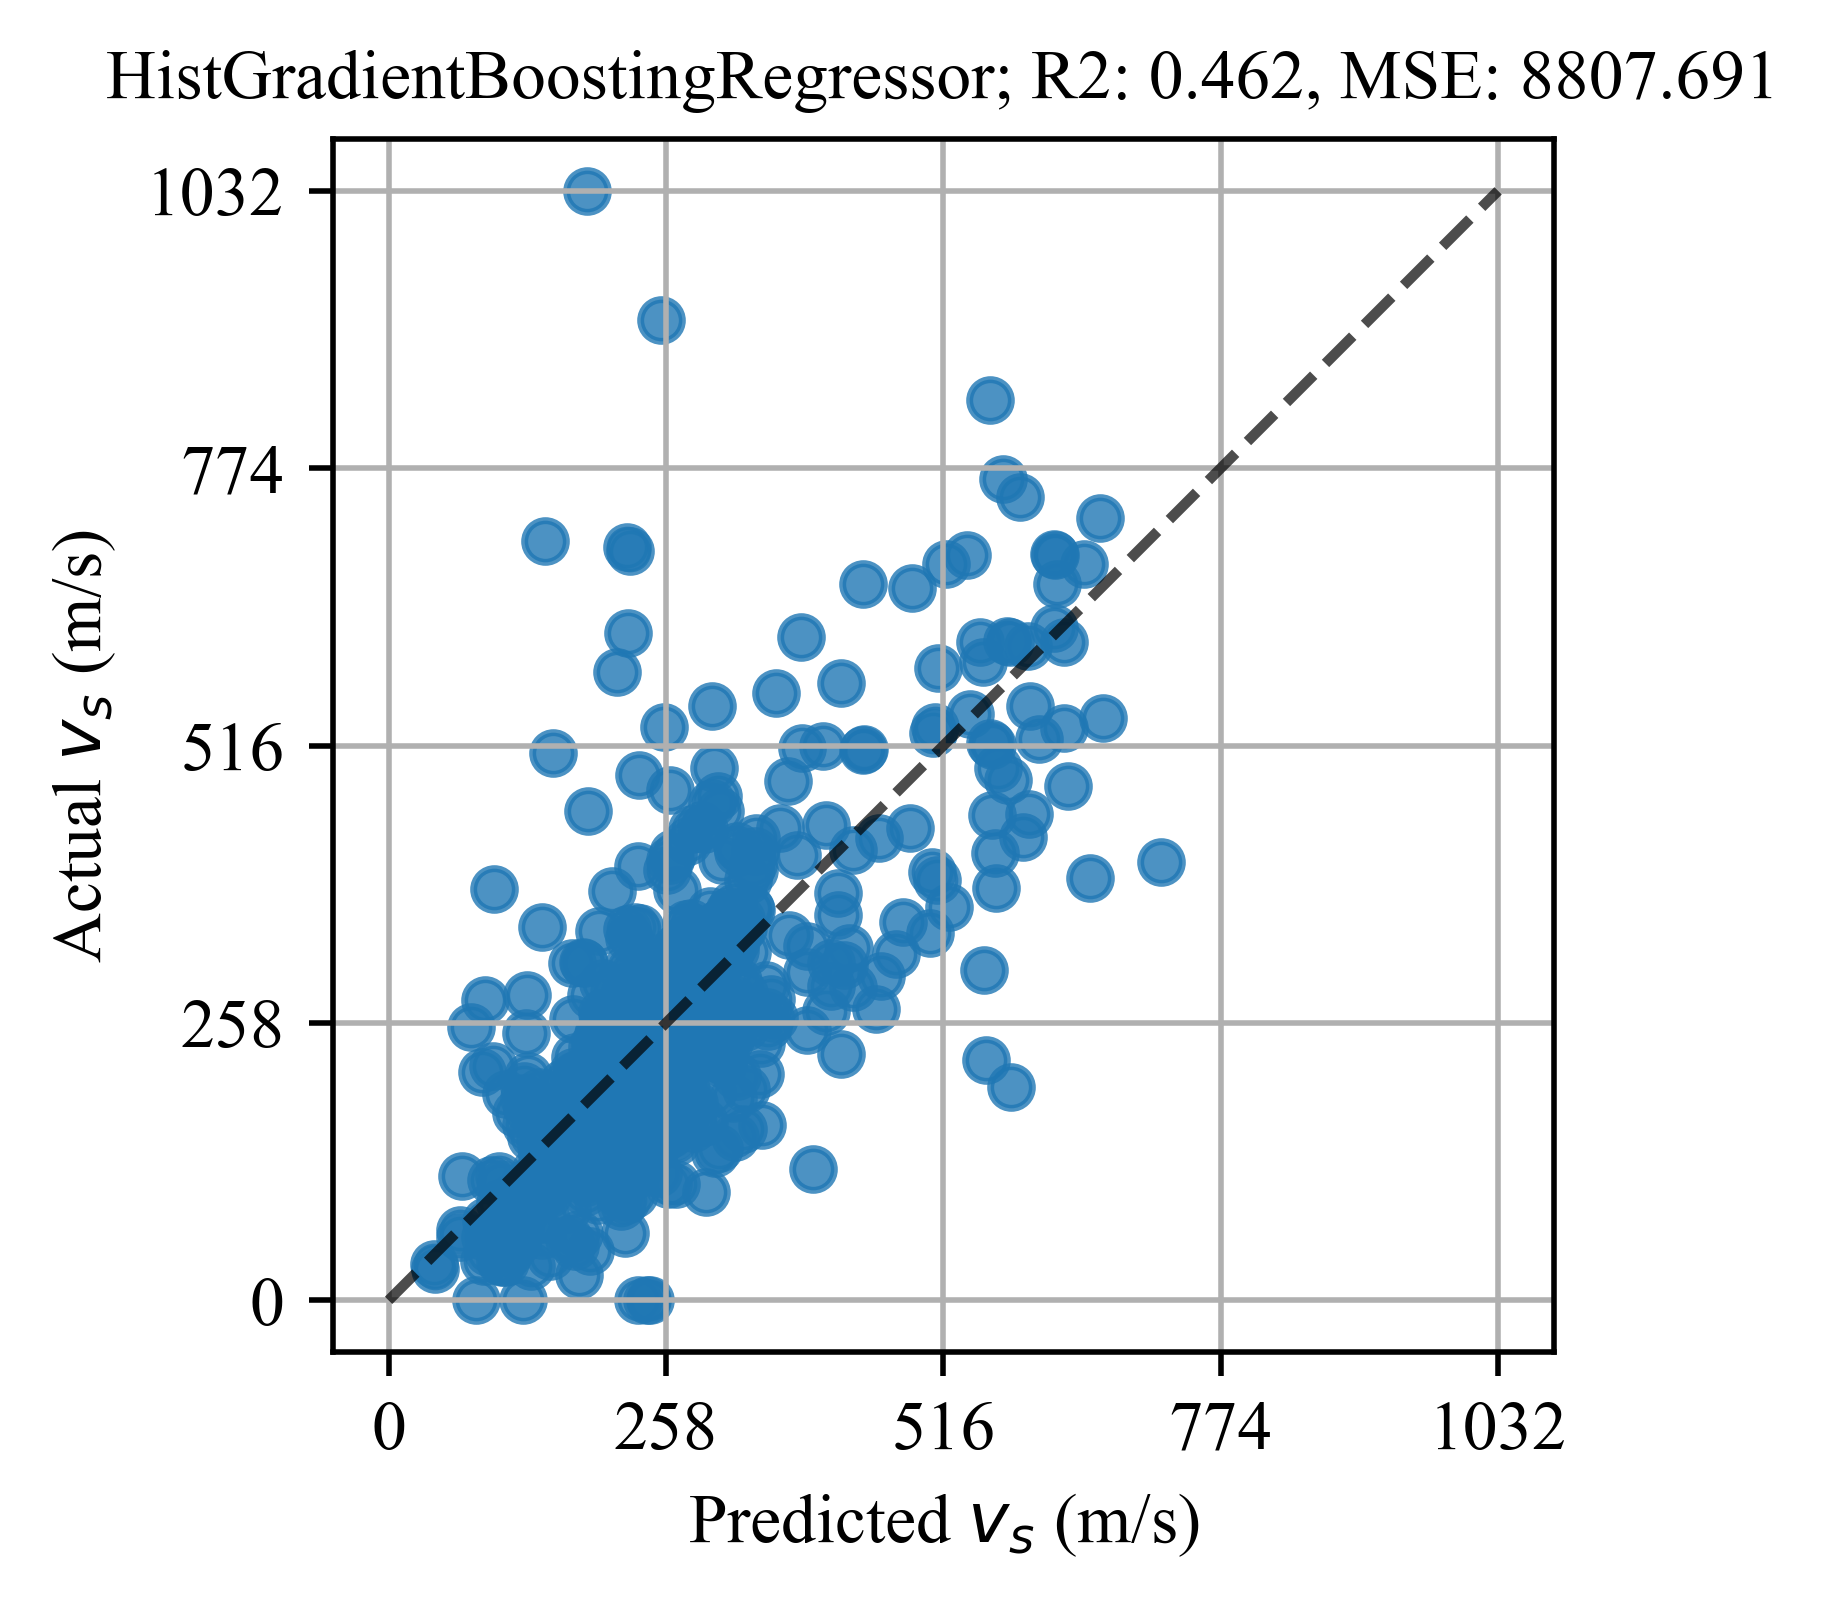

In [20]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'HistGradientBoostingRegressor; R2: {round(score, 3)}, MSE: {round(mse, 3)}')

In [21]:
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Training Data - R2: 0.68, MSE: 6745.927.


In [22]:
# Fit the model on the entire dataset with the best hyperparameters
final_model = HistGradientBoostingRegressor(**best_params, random_state=42)

# Fit the model on the entire dataset
final_model.fit(X, y)

joblib.dump(final_model, 'hist_model.joblib')

['hist_model.joblib']

In [23]:
from sklearn.ensemble import RandomForestRegressor

check_column = []
check = 0

for column in selected_columns_x[:-1]:
    if df_SCPTu_SCPT[column].isnull().any():
        check_column.append('nan')
        check = 0
    else:
        check_column.append('non_nan')
        check = 1

    if check == 0:
        # Handle the case when at least one column contains NaN values
        pass
    elif check == 1:
        # Drop rows with NaN values in the selected columns
        df_SCPTu_SCPT.dropna(subset=selected_columns_x[:-1], inplace=True)

X = df_SCPTu_SCPT[selected_columns_x[:-1]]
y = df_SCPTu_SCPT['Vs (m/s)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [24]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        'max_samples': trial.suggest_int('max_samples', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'n_jobs': None,
        'criterion': "squared_error",
    }
    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-06 22:17:23,147] A new study created in memory with name: no-name-49f28cac-cee9-4e1d-98c6-c4dbaae78725
[I 2024-02-06 22:17:26,881] Trial 0 finished with value: -0.002883157530127023 and parameters: {'n_estimators': 913, 'max_depth': 21, 'max_leaf_nodes': 39, 'max_samples': 12, 'min_samples_split': 42, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.002883157530127023.
[I 2024-02-06 22:17:28,505] Trial 1 finished with value: -0.002550801850242146 and parameters: {'n_estimators': 413, 'max_depth': 7, 'max_leaf_nodes': 26, 'max_samples': 37, 'min_samples_split': 50, 'min_samples_leaf': 33}. Best is trial 1 with value: -0.002550801850242146.
[I 2024-02-06 22:17:31,888] Trial 2 finished with value: -0.0025764977548282664 and parameters: {'n_estimators': 856, 'max_depth': 28, 'max_leaf_nodes': 5, 'max_samples': 48, 'min_samples_split': 16, 'min_samples_leaf': 45}. Best is trial 1 with value: -0.002550801850242146.
[I 2024-02-06 22:17:33,208] Trial 3 finished with value: -0.

In [25]:
# Plot optimization history
plot_optimization_history(study)

In [26]:
# Plot parameter importances
plot_param_importances(study)

In [27]:
best_params = {
    'n_estimators': 1,
    'max_depth': 1,
    'max_leaf_nodes': 2,
    'max_samples': 1,
    'min_samples_split': 1,
    'min_samples_leaf': 1,
    'n_jobs': None,
    'criterion': "squared_error",
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = RandomForestRegressor(**best_params,random_state=42)

# Train the final model on the entire training set
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_leaf_nodes=50, max_samples=48,
                      n_estimators=422, random_state=42)

In [28]:
print('Performance of 0.68 ML model:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of RandomForestRegressor ML model:

Test Data - R2: 0.462, MSE: 11359.632.


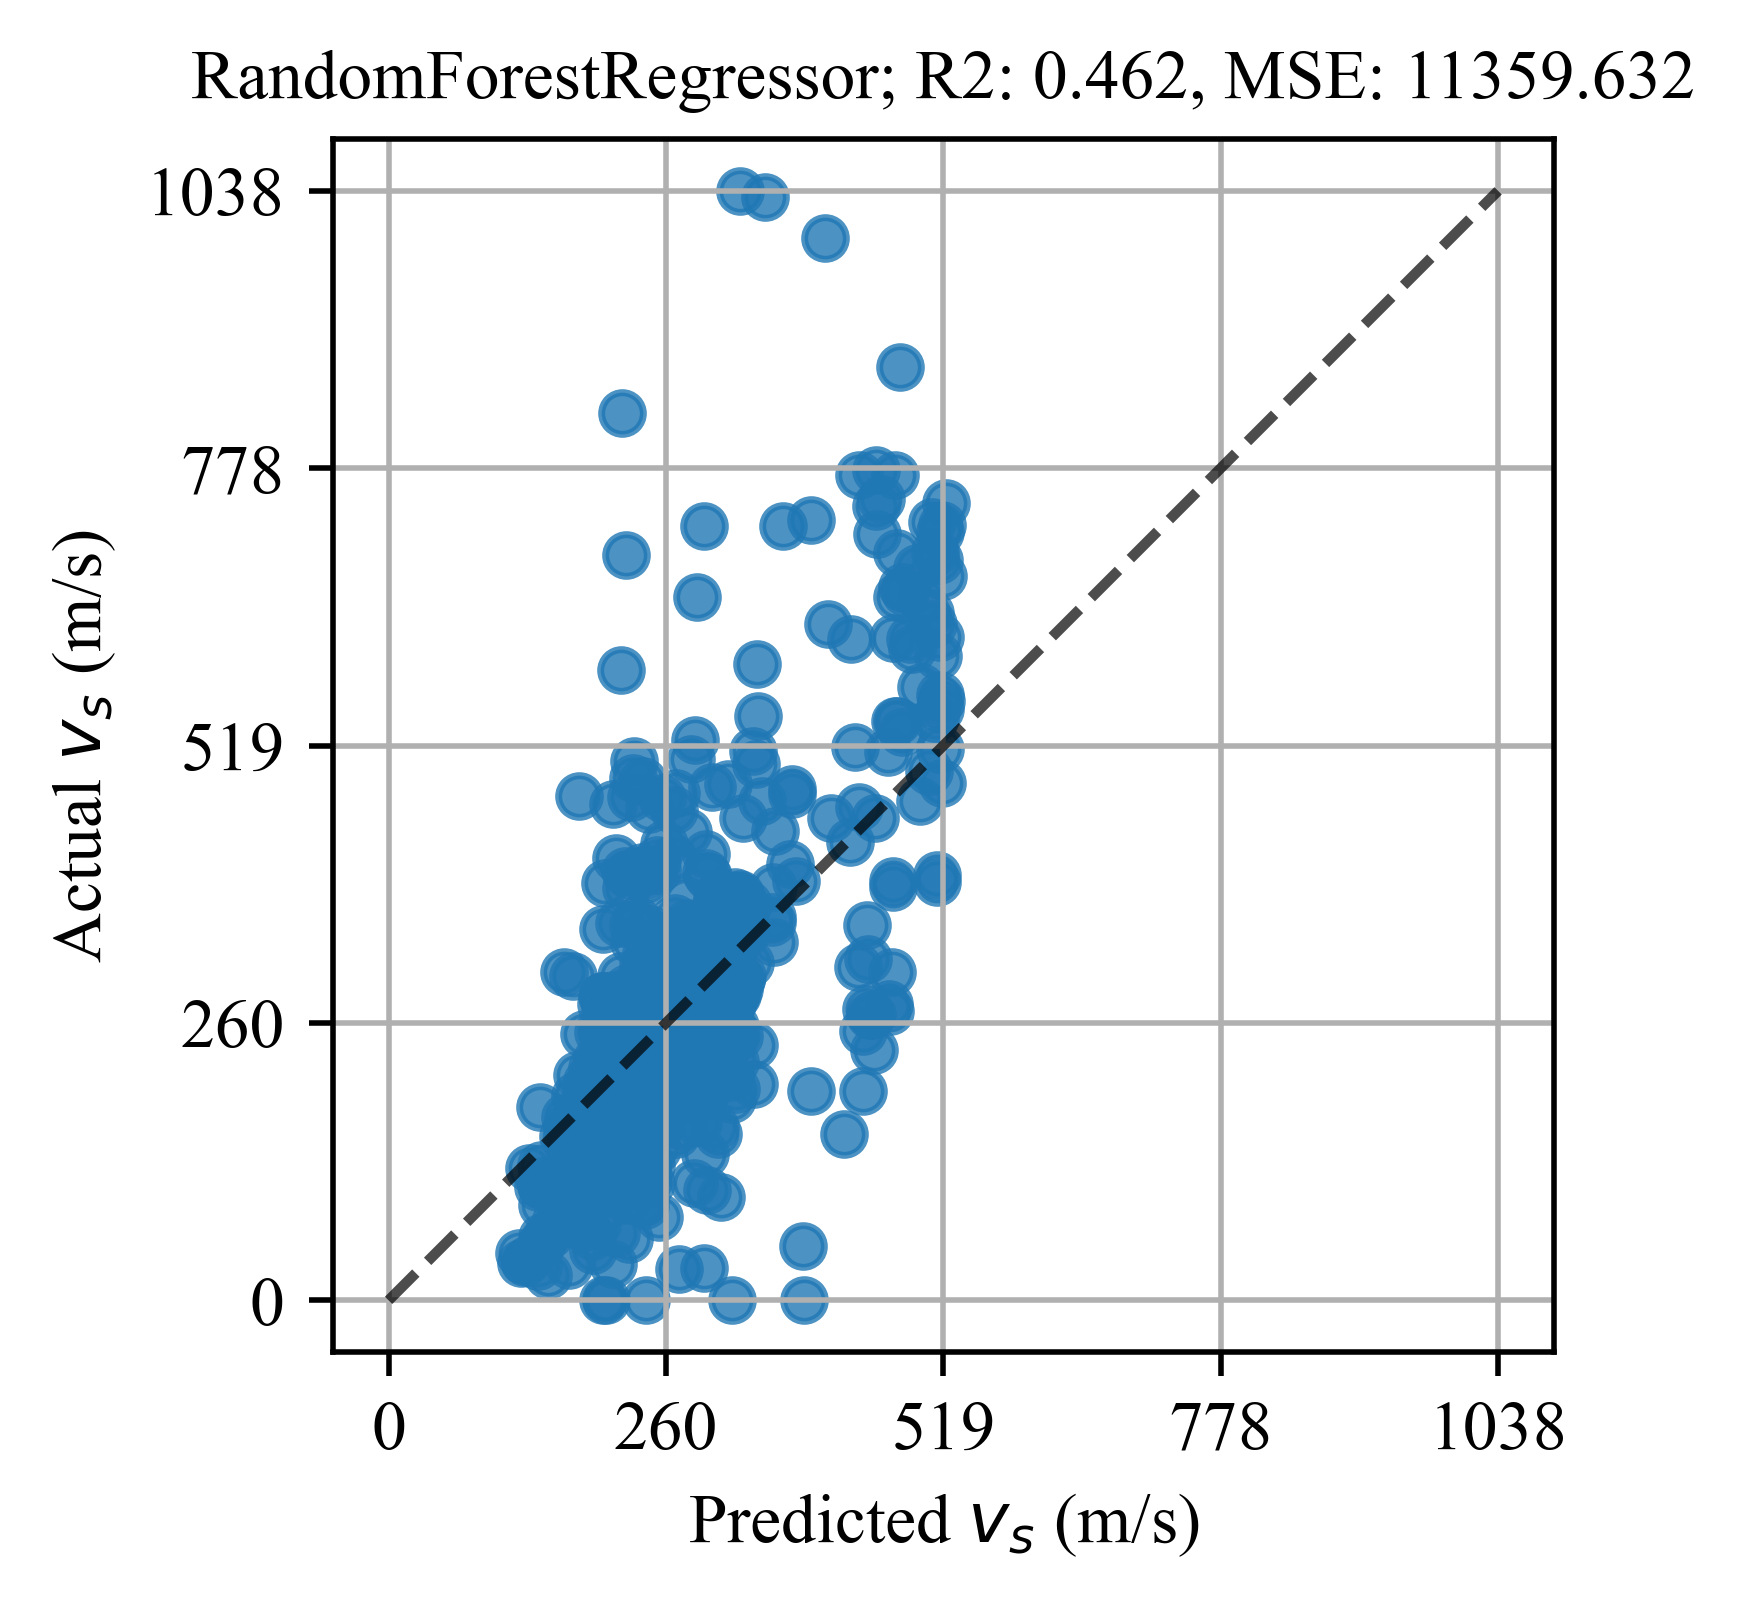

In [29]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'0.680.680.68; R2: {round(score, 3)}, MSE: {round(mse, 3)}')

In [30]:
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Training Data - R2: 0.348, MSE: 12885.388.


In [31]:
# Fit the model on the entire dataset with the best hyperparameters
final_model = RandomForestRegressor(**best_params, random_state=42)

# Fit the model on the entire dataset
final_model.fit(X, y)

joblib.dump(final_model, 'reg_model.joblib')

['reg_model.joblib']